In [36]:
import subprocess
import sys
import os
from datetime import datetime,timedelta,timezone
from typing import Optional,List,Tuple,Dict
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ccxt
import yfinance as yf

pd.options.display.float_format='{:.6f}'.format



In [41]:
def fetch_ohlcv(symbol, timeframe='1d', since='2017-01-01'):
    """Récupère l'OHLCV pour n'importe quel symbole"""
    print(f"--- Récupération des prix pour {symbol} ---")
    ex = ccxt.binance({'enableRateLimit': True})
    since_ms = int(pd.Timestamp(since, tz='UTC').timestamp() * 1000)
    all_ohlcv = []
    
    while True:
        try:
            ohlcv = ex.fetch_ohlcv(symbol, timeframe, since=since_ms, limit=1000)
            if not ohlcv: break
            all_ohlcv.extend(ohlcv)
            since_ms = ohlcv[-1][0] + 1
            if len(ohlcv) < 1000: break
        except Exception as e:
            print(f"Erreur fetch prix: {e}")
            break
            
    if not all_ohlcv:
        return pd.DataFrame()

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    df.set_index('timestamp', inplace=True)
    return df

def fetch_funding(symbol, limit=1000):
    """Construit automatiquement le ticker futures"""
    futures_symbol = f"{symbol}:USDT" 
    print(f"--- Récupération du Funding Rate pour {futures_symbol} ---")
    
    ex = ccxt.binance({'enableRateLimit': True, 'options': {'defaultType': 'future'}})
    rates = []
    # 4 ans d'historique max pour le funding
    since = int((datetime.now(tz=timezone.utc) - timedelta(days=365*4)).timestamp() * 1000)
    
    while True:
        try:
            batch = ex.fetch_funding_rate_history(futures_symbol, since=since, limit=limit)
            if not batch: break
            rates.extend(batch)
            since = batch[-1]['timestamp'] + 1
            if len(batch) < limit: break
        except Exception as e:
            print(f"Note: Funding rate non dispo ou erreur ({e})")
            break
            
    if not rates: 
        return pd.Series(dtype=float)
        
    df = pd.DataFrame(rates)
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True)
    df.set_index('datetime', inplace=True)
    return df['fundingRate']

In [42]:
def generate_pure_tsm_signals(prices: pd.Series, lookbacks: List[int]) -> pd.DataFrame:
    signals = pd.DataFrame(index=prices.index)
    for lb in lookbacks:
        raw_mom = prices.pct_change(lb)
        window_norm = 252
        rolling_mean = raw_mom.rolling(window_norm).mean()
        rolling_std = raw_mom.rolling(window_norm).std()
        z_mom = (raw_mom - rolling_mean) / rolling_std
        signals[f'tsm_{lb}'] = z_mom.clip(-3, 3)
    return signals.dropna()

In [43]:
class RollingPCAEngine:
    def __init__(self, window: int = 120):
        self.window = window
        
    def compute_signal(self, X: pd.DataFrame) -> pd.Series:
        rolling_mean = X.rolling(self.window).mean()
        rolling_std = X.rolling(self.window).std()
        X_norm = (X - rolling_mean) / rolling_std
        signal = X_norm.mean(axis=1)
        return signal

def run_pure_tsm_pca(prices: pd.Series, funding: Optional[pd.Series] = None, 
                     lookbacks: List[int] = [10, 30, 60, 90, 180, 365], 
                     pca_window: int = 120, target_vol: float = 0.90, 
                     max_leverage: float = 2.0, vol_floor: float = 0.20):
    
    prices = prices.dropna().sort_index()
    # Resample Hebdomadaire
    idx = prices.resample('W').last().index
    
    # 1. Signaux & PCA
    df_signals = generate_pure_tsm_signals(prices, lookbacks)
    pca = RollingPCAEngine(window=pca_window)
    pca_sig_daily = pca.compute_signal(df_signals)
    pca_sig_daily = pca_sig_daily.ewm(span=3).mean()
    signal_w = pca_sig_daily.reindex(idx, method='ffill').shift(1).fillna(0.0)
    
    # 2. Volatility Targeting
    r = prices.pct_change().dropna()
    vol_total = r.ewm(span=30).std() * np.sqrt(365)
    vol_w = vol_total.reindex(idx, method='ffill').clip(lower=vol_floor)
    
    leverage = (target_vol / vol_w).replace([np.inf, -np.inf], np.nan).fillna(0.0)
    leverage = leverage.clip(0, max_leverage)
    
    # 3. Position & PnL
    direction = np.where(signal_w > 0, 1.0, 0.0)
    pos = pd.Series(direction, index=idx) * leverage
    
    df = pd.DataFrame(index=idx)
    df['asset_return'] = prices.reindex(idx, method='ffill').pct_change().fillna(0.0)
    df['position'] = pos.fillna(0.0)
    df['cost'] = df['position'].diff().abs().fillna(0.0) * (10.0 / 10000.0)
    
    if funding is not None:
        fund_w = funding.resample('W').sum().reindex(idx).fillna(0.0)
        df['fund_pnl'] = fund_w * df['position']
    else:
        df['fund_pnl'] = 0.0
        
    df['net_ret'] = df['position'] * df['asset_return'] - df['cost'] + df['fund_pnl']
    df['equity'] = (1 + df['net_ret']).cumprod()
    
    return df

In [44]:
# Dictionnaire pour stocker les résultats de chaque coin
results_store = {}

print(f"Démarrage du backtest sur : {TICKERS}")

for ticker in TICKERS:
    print(f"\n{'='*40}")
    print(f"TRAITEMENT DE : {ticker}")
    print(f"{'='*40}")

    # 1. Chargement Prix
    df_asset = fetch_ohlcv(ticker, since='2017-01-01')
    
    if df_asset.empty:
        print(f"Warning: Pas de données pour {ticker}, passage au suivant.")
        continue

    # 2. Chargement Funding (Optionnel)
    try:
        fund = fetch_funding(ticker)
        if not fund.empty:
            fund = fund.groupby(level=0).last()
        else:
            fund = None
    except Exception as e:
        print(f"Warning Funding: {e}")
        fund = None

    # 3. Exécution Backtest
    # On garde tes paramètres qui marchent (target_vol=0.90)
    try:
        res = run_pure_tsm_pca(
            df_asset['close'], 
            funding=fund,
            lookbacks=[10, 21, 63, 126, 252], # Classique TSM
            pca_window=120,
            target_vol=0.90,
            max_leverage=2.0
        )
        # On sauvegarde le DataFrame complet du résultat
        results_store[ticker] = res
        final_equity = res['equity'].iloc[-1]
        print(f"--> Terminé pour {ticker}. Equity Finale: {final_equity:.2f}")
        
    except Exception as e:
        print(f"Erreur durant le calcul pour {ticker}: {e}")

print("\n--- TOUS LES BACKTESTS SONT TERMINÉS ---")

Démarrage du backtest sur : ['BTC/USDT', 'ETH/USDT', 'SOL/USDT', 'XRP/USDT', 'BNB/USDT']

TRAITEMENT DE : BTC/USDT
--- Récupération des prix pour BTC/USDT ---
--- Récupération du Funding Rate pour BTC/USDT:USDT ---
--> Terminé pour BTC/USDT. Equity Finale: 84.27

TRAITEMENT DE : ETH/USDT
--- Récupération des prix pour ETH/USDT ---
--- Récupération du Funding Rate pour ETH/USDT:USDT ---
--> Terminé pour ETH/USDT. Equity Finale: 67.81

TRAITEMENT DE : SOL/USDT
--- Récupération des prix pour SOL/USDT ---
--- Récupération du Funding Rate pour SOL/USDT:USDT ---
--> Terminé pour SOL/USDT. Equity Finale: 0.43

TRAITEMENT DE : XRP/USDT
--- Récupération des prix pour XRP/USDT ---
--- Récupération du Funding Rate pour XRP/USDT:USDT ---
--> Terminé pour XRP/USDT. Equity Finale: 1.24

TRAITEMENT DE : BNB/USDT
--- Récupération des prix pour BNB/USDT ---
--- Récupération du Funding Rate pour BNB/USDT:USDT ---
--> Terminé pour BNB/USDT. Equity Finale: 7.27

--- TOUS LES BACKTESTS SONT TERMINÉS ---



--- TABLEAU COMPARATIF ---
  Asset   Sharpe  Total Return  Max Drawdown
0   BTC 1.237502   8327.184795    -51.968546
1   ETH 1.139577   6680.575095    -49.963132
4   BNB 0.697907    627.226971    -78.476521
3   XRP 0.291394     23.716084    -74.957145
2   SOL 0.018037    -56.938404    -77.251204


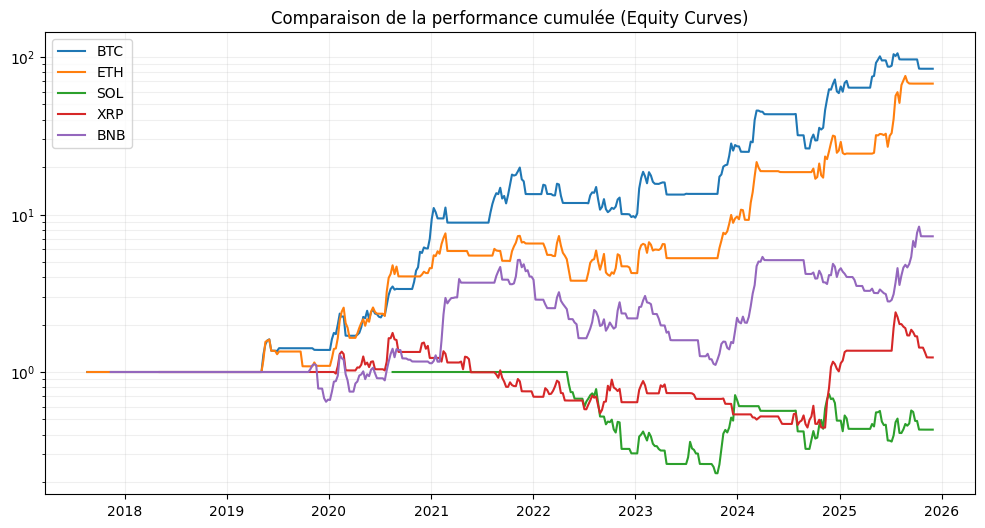

In [45]:
# Analyse des résultats
metrics = []

for ticker, df_res in results_store.items():
    # Calcul du Sharpe (Hebdomadaire -> Annualisé)
    # Formule: Moyenne des retours / Ecart-type * Racine(52 semaines)
    weekly_ret = df_res['net_ret']
    if weekly_ret.std() == 0:
        sharpe = 0
    else:
        sharpe = (weekly_ret.mean() / weekly_ret.std()) * np.sqrt(52)
        
    metrics.append({
        'Asset': ticker.split('/')[0], # Garde juste le nom (ex: BTC)
        'Sharpe': sharpe,
        'Total Return': (df_res['equity'].iloc[-1] - 1) * 100,
        'Max Drawdown': (df_res['equity'] / df_res['equity'].cummax() - 1).min() * 100
    })

# Création d'un DataFrame récapitulatif
df_metrics = pd.DataFrame(metrics).sort_values('Sharpe', ascending=False)

print("\n--- TABLEAU COMPARATIF ---")
print(df_metrics)

# --- VISUALISATION DU SHARPE ---
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

fig = go.Figure(data=[
    go.Bar(
        x=df_metrics['Asset'],
        y=df_metrics['Sharpe'],
        text=df_metrics['Sharpe'].apply(lambda x: f'{x:.2f}'),
        textposition='auto',
        marker_color=colors[:len(df_metrics)]
    )
])

fig.update_layout(
    title='Comparaison des Sharpe Ratios (Stratégie TSM + PCA)',
    xaxis_title='Actif',
    yaxis_title='Sharpe Ratio (Annualisé)',
    template='plotly_dark',
    height=500
)

fig.show()

# --- BONUS : GRAPHIQUE DES COURBES D'EQUITY ---
plt.figure(figsize=(12, 6))
for ticker, df_res in results_store.items():
    # On normalise pour que tout le monde parte de 1 au début de l'historique commun si possible
    # Ou on affiche juste l'equity brute calculée par ta fonction
    plt.plot(df_res.index, df_res['equity'], label=ticker.split('/')[0])

plt.title('Comparaison de la performance cumulée (Equity Curves)')
plt.yscale('log') # Log scale souvent mieux pour comparer crypto
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()